This notebook implements a very simple sequential network with pytorch. The dataset used is very small, and only used for some preliminary trials. The dataset is composed of three T1 images (class 0) and three FA images (class 1). The aim of this simple network is to classify images into the two classes.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms

torch.set_printoptions(edgeitems=2)
torch.manual_seed(0)

In [2]:
#mount the drive folder
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/work/my_tests

Mounted at /content/drive
/content/drive/My Drive/work/my_tests


In [3]:
#load the dataset as an instance of the class customDataset
import os
from customDataset import HCPanatDataset

img_dir = 'HCP-anat-data/images/'
dataset = HCPanatDataset(csv_file='HCP-anat-data/annotations.csv', root_dir=img_dir)

Training on device cpu.


In [4]:
#transform in torch tensor with transforms.ToTensor()
dataset_t = HCPanatDataset(csv_file='HCP-anat-data/annotations.csv', root_dir=img_dir, transform=transforms.ToTensor())

In [5]:
#compute the mean and std of the data
t1, _ = dataset[0]
max_dim = len(t1.shape) #concatenating dimension
imgs = torch.stack([img_t for img_t, _ in dataset_t], dim=max_dim)
mean = torch.mean(imgs)
std = torch.std(imgs)

In [6]:
#normalize the data
transformed_dataset = HCPanatDataset(
    csv_file='HCP-anat-data/annotations.csv', 
    root_dir=img_dir, 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean,std)]))

In [7]:
#split the dataset into training and test sets with torch.utils.data.random_split
from torch.utils.data import random_split
N = len(transformed_dataset)
perc_train = 0.8
train_set, test_set = random_split(transformed_dataset, [int(perc_train*N), N-int(perc_train*N)]) 
print("Total number of images: %i" %N)
print("Number of training images: %i" %(perc_train*N))
print("Number of test images: %i" %(N-int(perc_train*N)))

Total number of images: 6
Number of training images: 4
Number of test images: 2


In [8]:
#define the sequence of models with nn.Sequential()
import torch.nn as nn
n_in = imgs.shape[0] * imgs.shape[1] * imgs.shape[2] #number of input features
n_out = 2 #number of output features, i.e. number of classes
seq_model = nn.Sequential(
            nn.Linear(n_in, 128), 
            nn.Tanh(),
            nn.Linear(128, n_out))

In [9]:
#define the optimizer (SGD) and the loss (NLL)
import torch.optim as optim
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
loss = nn.NLLLoss()

In [10]:
#define hyperparameters
n_epochs = 20
batch_size = 1

In [11]:
#split the datasets into batches
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [12]:
#define the training loop
def training_loop_val(model, train_loader, test_loader, criterion, optimizer, n_epochs):
  "Training loop with training and validation loss"
  loss_vector = np.zeros(n_epochs)
  loss_val_vector = np.zeros(n_epochs)
  
  for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = criterion(outputs, labels)
                
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for imgs_test, labels_test in test_loader: 
        outputs_test = model(imgs_test.view(imgs_test.shape[0], -1))
        loss_test = criterion(outputs_test, labels_test)

    loss_vector[epoch] = float(loss)
    loss_val_vector[epoch] = float(loss_test)    
    print("Epoch: %d, Training Loss: %f, Validation Loss: %f" %(epoch, float(loss), float(loss_test)))    

  return loss_vector, loss_val_vector

In [13]:
#training and showing also validation loss
import time
t0 = time.time()
loss_vector, loss_val_vector = training_loop_val(
    model = seq_model,
    train_loader = train_loader,
    test_loader = test_loader,
    criterion = loss,
    optimizer = optimizer,
    n_epochs = n_epochs)
print("Training time = %f seconds" %(time.time()-t0))

Epoch: 0, Training Loss: -5.812010, Validation Loss: -1.773671
Epoch: 1, Training Loss: -1.902688, Validation Loss: -6.202877
Epoch: 2, Training Loss: -2.160743, Validation Loss: -2.289760
Epoch: 3, Training Loss: -2.418772, Validation Loss: -6.718877
Epoch: 4, Training Loss: -6.847877, Validation Loss: -2.805797
Epoch: 5, Training Loss: -2.934803, Validation Loss: -7.234877
Epoch: 6, Training Loss: -7.363877, Validation Loss: -7.492877
Epoch: 7, Training Loss: -7.621878, Validation Loss: -3.579819
Epoch: 8, Training Loss: -7.879878, Validation Loss: -8.008879
Epoch: 9, Training Loss: -3.966825, Validation Loss: -4.095827
Epoch: 10, Training Loss: -8.395877, Validation Loss: -4.353828
Epoch: 11, Training Loss: -8.653878, Validation Loss: -4.611831
Epoch: 12, Training Loss: -4.740831, Validation Loss: -4.869832
Epoch: 13, Training Loss: -4.998833, Validation Loss: -9.298880
Epoch: 14, Training Loss: -5.256833, Validation Loss: -5.385835
Epoch: 15, Training Loss: -9.685878, Validation Lo

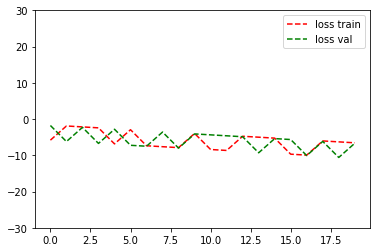

In [14]:
#plot training and validation loss
x_axis = np.arange(n_epochs)
plt.plot(x_axis, loss_vector, 'r--', label='loss train')
plt.plot(x_axis, loss_val_vector, 'g--', label='loss val')
plt.ylim(-30, 30)
plt.legend()

In [15]:
#check accuracy
def check_accuracy(loader, model):

  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for imgs, labels in loader:
      outputs = model(imgs.view(imgs.shape[0], -1))
      _, predicted = torch.max(outputs, dim=1)
      total += labels.shape[0]
      correct += int((predicted == labels).sum())
        
  print("Accuracy: %f" % (correct / total))

In [16]:
#compute accuracy in training
check_accuracy(train_loader, seq_model)

Accuracy: 1.000000


In [17]:
#compute accuracy in test
check_accuracy(test_loader, seq_model)

Accuracy: 1.000000


We can decrease the training time using a GPU.